In [1]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse import csr_matrix
from scipy.spatial import cKDTree
from scipy.sparse.csgraph import dijkstra
from concurrent.futures import ProcessPoolExecutor, as_completed
from multiprocessing import Pool, shared_memory
from numba import njit, types
from numba.typed import Dict
import pandana.network as pdna
import time


In [2]:
DATA_DIR = r"C:\Users\david.hensle\OneDrive - Resource Systems Group, Inc\Documents\projects\sandag\bike_route_choice\network"

In [3]:
# Global Variables for Network Size
NUM_NODES = 10000  # Changeable number of nodes -- only applies to dummy network
NUM_CENTROIDS = 1000  # Number of centroids (randomly selected nodes)

# San Diego County Approximate Size (in miles)
SAN_DIEGO_LAT_MIN, SAN_DIEGO_LAT_MAX = 0, 10  
SAN_DIEGO_LON_MIN, SAN_DIEGO_LON_MAX = 0, 10

# Global Variables for Network Size
NUM_PROCESSORS = 1
MAX_DISTANCE = 10  # Maximum distance for Dijkstra's algorithm to search for shortest paths

In [4]:
def read_bike_network_data(num_centroids=0):
    """Read actual bike network data from CSV files."""
    print("Reading network data from ", DATA_DIR)
    nodes = pd.read_csv(os.path.join(DATA_DIR, "derivedBikeNodes.csv"))
    edges = pd.read_csv(os.path.join(DATA_DIR, "derivedBikeEdges.csv"))
    traversals = pd.read_csv(os.path.join(DATA_DIR, "derivedBikeTraversals.csv"))

    # take the first n centroids for testing smaller samples
    if num_centroids > 0:
        new_centroids = nodes[nodes.centroid].sample(num_centroids).index
        nodes.centroid = False
        nodes.loc[new_centroids, 'centroid'] = True

    print(f"Nodes: {nodes.shape} Edges: {edges.shape} Traversals: {traversals.shape}")

    return nodes, edges, traversals

In [5]:
# Generate Random Node Positions within San Diego County
def generate_random_nodes(num_nodes):
    latitudes = np.random.uniform(SAN_DIEGO_LAT_MIN, SAN_DIEGO_LAT_MAX, num_nodes)
    longitudes = np.random.uniform(SAN_DIEGO_LON_MIN, SAN_DIEGO_LON_MAX, num_nodes)
    return np.column_stack((latitudes, longitudes))


def create_edges(nodes, max_neighbors=4):
    node_positions = nodes[['x', 'y']].values
    node_ids = nodes['id'].to_numpy()
    tree = cKDTree(node_positions)
    edges = []

    # Find the nearest neighbors for all nodes
    distances, indices = tree.query(node_positions, k=max_neighbors)

    edges = [
        (node_ids[i], node_ids[j], dist)
        for i in range(len(nodes))
        for j, dist in zip(indices[i][1:], distances[i][1:])  # Skip the node itself (index 0)
    ]
    return edges


def create_dummy_network():
    """
    Create a dummy network with the same format as the actual data.
    Generates nodes with random coordinates and edges between them.
    """
    print("Creating a dummy network...")
    # Generate Random Node Positions within San Diego County
    num_nodes = NUM_NODES
    nodes = generate_random_nodes(num_nodes)

    # Create a DataFrame for nodes similar to the actual data format
    nodes_df = pd.DataFrame({
        'id': np.arange(num_nodes),
        'x': nodes[:, 0],
        'y': nodes[:, 1],
        'mgra': np.zeros(num_nodes, dtype=int),
        'taz': np.zeros(num_nodes, dtype=int),
        'signalized': False,
        'centroid': False
    })
    centroids = nodes_df.sample(NUM_CENTROIDS).index  # Randomly select centroids
    nodes_df.loc[centroids, 'centroid'] = True
    nodes_df.loc[centroids, 'mgra'] = np.arange(1, NUM_CENTROIDS + 1)  # Assign unique MGRA to centroids
    nodes_df.loc[centroids, 'taz'] = np.arange(1, NUM_CENTROIDS + 1)  # Assign unique TAZ to centroids

    # Create random edges between nodes
    edges = create_edges(nodes_df, max_neighbors=5)

    # Create a DataFrame for edges similar to the actual data format
    edges_df = pd.DataFrame(edges, columns=['fromNode', 'toNode', 'distance'])
    edges_df['bikeClass'] = np.random.randint(1, 4, size=len(edges))  # Random bike class
    edges_df['lanes'] = np.random.randint(1, 3, size=len(edges))  # Random number of lanes
    edges_df['functionalClass'] = np.random.randint(1, 6, size=len(edges))  # Random functional class
    edges_df['autosPermitted'] = np.random.choice([True, False], size=len(edges))  # Random autos permitted flag
    edges_df['cycleTrack'] = np.random.choice([True, False], size=len(edges))  # Random cycle track flag
    edges_df['bikeBlvd'] = np.random.choice([True, False], size=len(edges))  # Random bike boulevard flag
    edges_df['gain'] = np.random.uniform(-10, 10, size=len(edges))  # Random gain (elevation)
    edges_df['bikeCost'] = np.random.uniform(0, 5, size=len(edges))  # Random bike cost
    edges_df['walkCost'] = np.random.uniform(0, 5, size=len(edges))  # Random walk cost
    edges_df['centroidConnector'] = np.where(edges_df['fromNode'].isin(centroids) | edges_df['toNode'].isin(centroids), True, False)

    return nodes_df, edges_df

In [6]:
def plot_shortest_path_with_results(nodes, edges, shortest_path_df, origin, destination, buffer_size=None):
    """Plot the shortest path between two nodes with additional path information within a square buffer around the origin node."""
    print("Plotting the shortest path...")
    path_data = shortest_path_df[(shortest_path_df.origin == origin) & (shortest_path_df.destination == destination)]
    if path_data.empty:
        print(f"No path found between {origin} and {destination}")
        return

    # Get the coordinates of the origin node
    origin_node = nodes[nodes['id'] == origin].iloc[0]
    origin_x, origin_y = origin_node['x'], origin_node['y']

    if buffer_size:
        # Define the buffer boundaries
        min_x, max_x = origin_x - buffer_size, origin_x + buffer_size
        min_y, max_y = origin_y - buffer_size, origin_y + buffer_size

        # Filter nodes within the buffer
        filtered_nodes = nodes[(nodes['x'] >= min_x) & (nodes['x'] <= max_x) & (nodes['y'] >= min_y) & (nodes['y'] <= max_y)]

        # Filter edges to include only those with both nodes within the buffer
        filtered_edges = edges[edges['fromNode'].isin(filtered_nodes['id']) & edges['toNode'].isin(filtered_nodes['id'])]

        # check to make sure destination node is also in the buffer
        if destination not in filtered_nodes['id'].values:
            print(f"Destination node {destination} is not in the buffer size of {buffer_size}")

    else:
        filtered_nodes = nodes
        filtered_edges = edges

    # Create a graph from the filtered nodes and edges
    G = nx.Graph()
    G.add_nodes_from([(node['id'], {'pos': (node['x'], node['y'])}) for _, node in filtered_nodes.iterrows()])
    G.add_edges_from([(edge.fromNode, edge.toNode, {'weight': edge.distance}) for _, edge in filtered_edges.iterrows()])

    # Extract positions for plotting
    pos = nx.get_node_attributes(G, 'pos')

    # Plot the network
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, node_size=10, with_labels=False, edge_color='gray', alpha=0.5, width=0.5)

    # Highlight the shortest path
    path_edges = [(path_data.fromNode.iloc[i], path_data.toNode.iloc[i]) for i in range(len(path_data))]
    path_nodes = set(path_data.fromNode).union(set(path_data.toNode))
    nx.draw_networkx_nodes(G, pos, nodelist=path_nodes, node_color='red', node_size=50, label="Path Nodes")
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='blue', width=2, label="Shortest Path")

    # Highlight the origin and destination nodes
    nx.draw_networkx_nodes(G, pos, nodelist=[origin], node_color='green', node_size=100, label="Origin")
    nx.draw_networkx_nodes(G, pos, nodelist=[destination], node_color='purple', node_size=100, label="Destination")

    # Calculate path information
    num_edges = len(path_edges)
    total_distance = path_data['distance'].sum()

    # Add path information to the plot
    info_text = (f"Origin: {origin}\n"
                 f"Destination: {destination}\n"
                 f"Number of Edges: {num_edges}\n"
                 f"Total Distance: {total_distance:.2f} units")
    plt.text(0.05, 0.95, info_text, transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

    # Add a legend
    plt.legend(loc="upper right")
    plt.title(f"Shortest Path from Node {origin} to Node {destination}")
    plt.show(block=True)

In [7]:
# Perform Dijkstra's Algorithm for Each Centroid
def perform_dijkstra_networkx(nodes_df, edges_df, centroids):
    """
    Perform Dijkstra's algorithm for each centroid in the network.

    Args:
        nodes_df (pd.DataFrame): DataFrame containing node information.
        edges_df (pd.DataFrame): DataFrame containing edge information.
        centroids (list): List of centroid node IDs.

    Returns:
        dict: A dictionary with centroids as keys and tuples of shortest path lengths and paths as values.
    """
    # Create a graph from the edges
    G = nx.Graph()
    G.add_nodes_from((node_id, {'pos': (row['x'], row['y'])}) for node_id, row in nodes_df.iterrows())
    G.add_edges_from((row['fromNode'], row['toNode'], {'weight': row['distance']}) for _, row in edges_df.iterrows())

    # Perform Dijkstra's algorithm for each centroid
    shortest_paths = {}
    for centroid in centroids:
        # Get the shortest paths from this centroid to all other nodes
        lengths, paths = nx.single_source_dijkstra(G, centroid, weight='weight')
        shortest_paths[centroid] = (lengths, paths)  # Store the shortest path lengths and paths for this centroid

    return shortest_paths

def perform_dijkstra_paths_networkx(nodes_df, edges_df, centroids):
    """
    Perform Dijkstra's algorithm for each centroid in the network.

    Args:
        nodes_df (pd.DataFrame): DataFrame containing node information.
        edges_df (pd.DataFrame): DataFrame containing edge information.
        centroids (list): List of centroid node IDs.

    Returns:
        dict: A dictionary with centroids as keys and dictionaries of shortest paths to other centroids as values.
    """
    # Create a graph from the edges
    G = nx.Graph()
    G.add_nodes_from((node_id, {'pos': (row['x'], row['y'])}) for node_id, row in nodes_df.iterrows())
    G.add_edges_from((row['fromNode'], row['toNode'], {'weight': row['distance']}) for _, row in edges_df.iterrows())

    # Perform Dijkstra's algorithm for each centroid
    shortest_paths = {}
    for from_centroid in centroids:
        paths = {}
        for to_centroid in centroids:
            if from_centroid != to_centroid:
                path = nx.dijkstra_path(G, from_centroid, to_centroid, weight='weight')
                paths[to_centroid] = path
        shortest_paths[from_centroid] = paths

    return shortest_paths

In [8]:
def compute_centroid_paths_with_pandana(nodes, edges, centroids, limit=3):
    """
    Compute shortest paths and full paths between centroids within a specified distance using Pandana,
    and output the results in a long format DataFrame.

    Args:
        nodes (list): List of node coordinates [(x1, y1), (x2, y2), ...].
        edges (list): List of edges [(node1, node2, weight), ...].
        centroids (list): List of centroid indices.
        limit (float): Maximum distance to consider.

    Returns:
        pd.DataFrame: A DataFrame with columns ['origin', 'destination', 'A_node', 'B_node', 'node_num', 'distance'].
    """
    # Create a Pandana network
    network = pdna.Network(
        nodes.set_index('id')["x"],
        nodes.set_index('id')["y"],
        edges["fromNode"],
        edges["toNode"],
        edges["distance"].to_frame(), 
        twoway=False
    )
    # Precompute distances up to the limit
    network.precompute(distance=limit)


    # Create all origin-destination pairs
    centroids = np.array(centroids)
    origins, destinations = np.meshgrid(centroids, centroids)

    # Flatten the arrays and exclude pairs where origin == destination
    origins = origins.flatten()
    destinations = destinations.flatten()

    # Filter out pairs where origin == destination
    valid_indices = origins != destinations
    origins = origins[valid_indices]
    destinations = destinations[valid_indices]

    # Calculate paths using Pandana's shortest_paths
    paths = network.shortest_paths(origins, destinations, imp_name="distance")

    # Optimize path flattening using NumPy and Pandas
    paths_data = []
    for origin, destination, path in zip(origins, destinations, paths):
        if len(path) > 1:  # Ensure valid paths
            num_segments = len(path) - 1
            paths_data.append(pd.DataFrame({
                "origin": [origin] * num_segments,
                "destination": [destination] * num_segments,
                "A_node": path[:-1],  # All but the last node
                "B_node": path[1:],  # All but the first node
                "node_num": np.arange(1, num_segments + 1)  # Path segment indices
            }))

    # Concatenate all path segments into a single DataFrame
    long_format_df = pd.concat(paths_data, ignore_index=True)

    # Merge distances from edges_df
    long_format_df = long_format_df.merge(
        edges, on=["A_node", "B_node"], how="left"
    )

    return long_format_df


In [9]:
@njit
def reconstruct_path(predecessors, destination):
    path = []
    current = destination
    while current != -9999:  # -9999 indicates no predecessor
        path.append(current)
        current = predecessors[current]
    return path[::-1]  # Reverse the path to start from the origin


@njit
def process_paths(origin, distances, predecessors, centroids):
    rows = []

    reachable_mask = np.isfinite(distances)
    reachable_indices = np.flatnonzero(reachable_mask)

    for destination in reachable_indices:
        # do not create a row if the destination is not to a centroid
        if destination not in centroids:
            continue

        # Reconstruct the path from the predecessors array
        path = reconstruct_path(predecessors, destination)

        # Add rows for each node in the path
        for path_node_num, path_node in enumerate(path):
            rows.append((origin, destination, path_node_num, path_node))

    return rows


def convert_shortest_paths_to_long_df_numba(shortest_paths, edges, node_mapping):
    """
    Convert the output of perform_dijkstra_scipy into a pandas DataFrame in long format.

    Args:
        shortest_paths (dict): A dictionary with centroids as keys and tuples of shortest path lengths
                               and predecessors as values.

    Returns:
        pd.DataFrame: A DataFrame with shortest path information where each row is an edge in the path
    """
    print("Converting shortest paths to pandas dataframe...")

    print("Processing paths with numba...")
    centroids = list(shortest_paths.keys())
    rows = []
    for origin, (distances, predecessors) in shortest_paths.items():
        rows.extend(process_paths(origin, distances, predecessors, centroids))


    print("Creating dataframe...")
    rows = np.array(rows)
    sp_df = pd.DataFrame(rows, columns=['origin', 'destination', 'path_node_num', 'toNode'])
    # convert the 0 index node id back to the actual node id
    reverse_map = {v: k for k, v in node_mapping.items()}
    sp_df['origin'] = sp_df['origin'].map(reverse_map)
    sp_df['destination'] = sp_df['destination'].map(reverse_map)
    sp_df['toNode'] = sp_df['toNode'].map(reverse_map)

    sp_df['path_id'] = sp_df.groupby(['origin', 'destination']).ngroup()
    sp_df['fromNode'] = sp_df.groupby('path_id')['toNode'].shift(1)
    sp_df = sp_df[sp_df['toNode'] != sp_df['origin']]  # Remove the dummy start rows
    sp_df['fromNode'] = sp_df['fromNode'].astype(int)

    # merging edge attributes onto sp_df
    sp_df = sp_df.merge(
        edges[['fromNode', 'toNode', 'distance']], 
        how='left',
        on=['fromNode', 'toNode'],
    )

    return sp_df

In [10]:
def _perform_dijkstra(centroids, adjacency_matrix, limit=3):
    """Perform Dijkstra's algorithm for a batch of centroids."""
    print(f"Processing Dijkstra's on {len(centroids)} centroids with limit={limit}...")
    distances, predecessors = dijkstra(
        adjacency_matrix, directed=False, indices=centroids, return_predecessors=True, limit=limit
    )
    shortest_paths = {}
    for centroid, distance_mat, predecessor_mat in zip(centroids, distances, predecessors):
        shortest_paths[centroid] = (distance_mat, predecessor_mat)

    return shortest_paths


def perform_dijkstras_algorithm(nodes, edges, limit=3, num_processors=4):
    """Perform Dijkstra's algorithm for centroids using SciPy's sparse graph solver with batched parallel processing."""
    num_nodes = len(nodes)

    # node mapping needs to start at 0 in order to create adjacency matrix
    node_mapping = {node_id: idx for idx, node_id in enumerate(nodes.id)}

    # Create a sparse adjacency matrix
    row = edges.fromNode.map(node_mapping).to_numpy()
    col = edges.toNode.map(node_mapping).to_numpy()
    data = edges.distance.to_numpy()
    adjacency_matrix = csr_matrix((data, (row, col)), shape=(num_nodes, num_nodes))

    # Get centroids (nodes with 'centroid' flag True)
    centroids = nodes[nodes['centroid']].id.map(node_mapping).tolist()

    print(f"Need to calculate Dijkstra's on {len(centroids)} centroids with {num_processors} processors")

    if num_processors > 1:
        # Split centroids into batches
        centroid_batches = np.array_split(centroids, num_processors)

        shortest_paths = {}
        with Pool(processes=num_processors) as pool:
            results = pool.map(_perform_dijkstra, [(batch, adjacency_matrix, limit) for batch in centroid_batches])
            for batch_result in results:
                shortest_paths.update(batch_result)

    else:
        # Perform Dijkstra's algorithm for all centroids
        shortest_paths = _perform_dijkstra(centroids, adjacency_matrix, limit)

    return shortest_paths, node_mapping

In [11]:
def summarize_shortest_paths(sp_df):
    print("Total number of edges in shortest path dataframe: ", len(sp_df))
    print("Number of unique paths: ", sp_df['path_id'].nunique())
    print("Number of unique origin-destination pairs: ", sp_df[['origin', 'destination']].drop_duplicates().shape[0])
    print("Total number of possible OD pairs: ", len(sp_df['origin'].unique()) * len(sp_df['destination'].unique()))
    print("Percentage of possible OD pairs with a path: ", round(sp_df['path_id'].nunique() / len(sp_df['origin'].unique()) / len(sp_df['destination'].unique()), 4) * 100)
    summary = sp_df.groupby(['origin', 'destination']).agg(
        {'distance': 'sum', 'path_node_num': 'max'}).reset_index().rename(
        columns={'path_node_num': 'num_edges_per_path'}).describe()
    print(summary)
    return

In [12]:
nodes, edges, traversals = read_bike_network_data(num_centroids=NUM_CENTROIDS)
# nodes, edges = create_dummy_network()

Reading network data from  C:\Users\david.hensle\OneDrive - Resource Systems Group, Inc\Documents\projects\sandag\bike_route_choice\network
Nodes: (156899, 7) Edges: (372305, 13) Traversals: (737622, 11)


In [13]:
# other implementations
# sp_df = compute_centroid_paths_with_pandana(nodes, edges, nodes[nodes.centroid].index, limit=MAX_DISTANCE)
# shortest_paths = perform_dijkstra_paths_networkx(nodes, edges, nodes[nodes.centroid].id.to_list())
# shortest_paths = perform_dijkstra_networkx(nodes, edges, nodes[nodes.centroid].id.to_list())

In [14]:
# Perform Dijkstra's algorithm
shortest_paths, node_mapping = perform_dijkstras_algorithm(nodes, edges, limit=MAX_DISTANCE, num_processors=NUM_PROCESSORS)

Need to calculate Dijkstra's on 1000 centroids with 1 processors
Processing Dijkstra's on 1000 centroids with limit=10...


In [15]:
sp_df = convert_shortest_paths_to_long_df_numba(shortest_paths, edges, node_mapping)

Converting shortest paths to pandas dataframe...
Processing paths with numba...
Creating dataframe...


In [16]:
summarize_shortest_paths(sp_df)

Total number of edges in shortest path dataframe:  10550970
Number of unique paths:  133998
Number of unique origin-destination pairs:  133998
Total number of possible OD pairs:  984064
Percentage of possible OD pairs with a path:  13.62
             origin   destination       distance  num_edges_per_path
count  1.339980e+05  1.339980e+05  133998.000000       133998.000000
mean   1.173146e+08  1.173146e+08       6.305522           78.739757
std    3.782743e+07  3.782743e+07       2.417566           37.805300
min    1.000000e+08  1.000000e+08       0.111472            2.000000
25%    1.000050e+08  1.000050e+08       4.527221           51.000000
50%    1.000111e+08  1.000111e+08       6.594098           75.000000
75%    1.000191e+08  1.000191e+08       8.353175          102.000000
max    2.000049e+08  2.000049e+08       9.999979          243.000000


Plotting the shortest path...


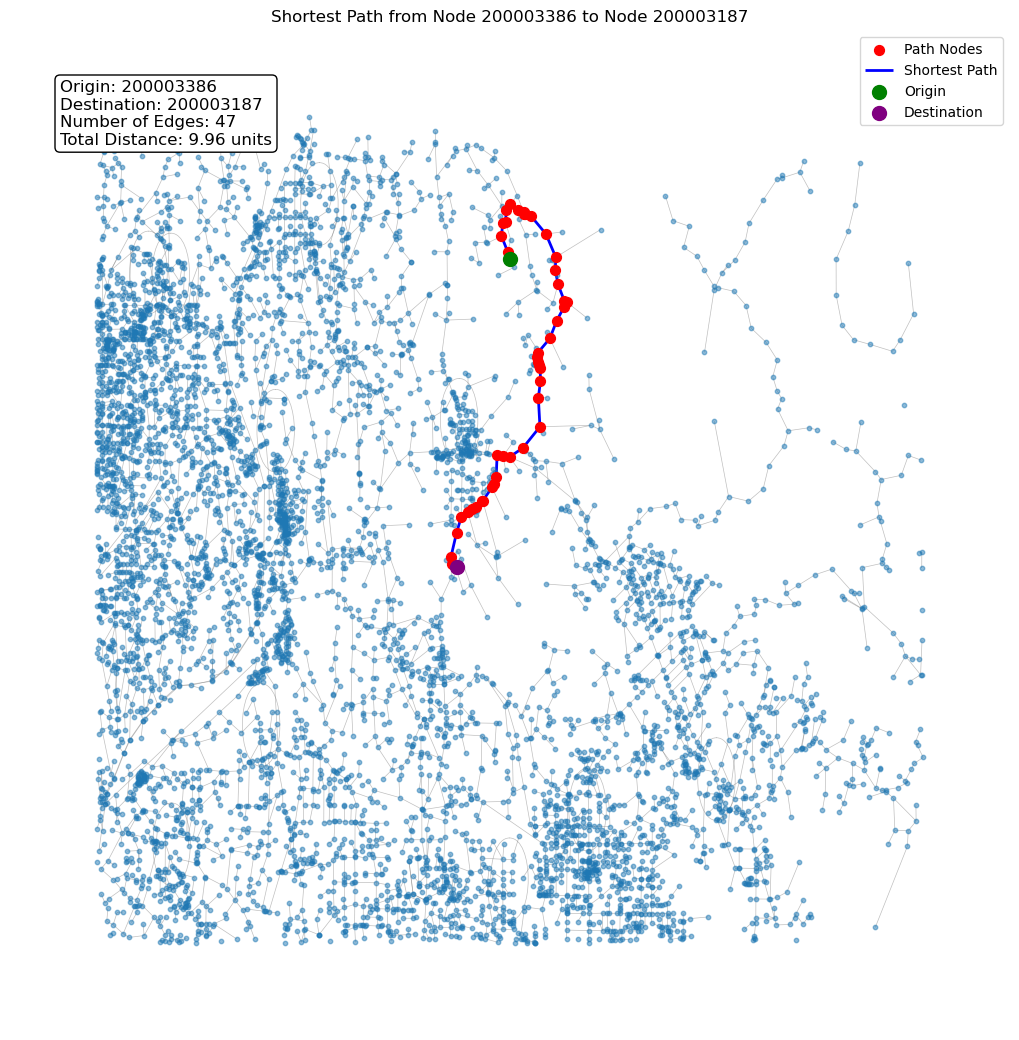

In [17]:
# Plot the network and shortest path between two random centroids
origin = sp_df.loc[0, 'origin']  # Use the first centroid
destination = sp_df.loc[0, 'destination']  # Use the second centroid
plot_shortest_path_with_results(nodes, edges, sp_df, origin, destination, buffer_size=5280*MAX_DISTANCE)

In [ ]:
def measure_scipy_performance(num_centroids_list):
    times = []

    for num_centroids in num_centroids_list:
        start_time = time.time()
        
        # Run the actual data processing with the specified number of centroids
        nodes, edges, traversals = read_bike_network_data(num_centroids=num_centroids)
        shortest_paths, node_mapping = perform_dijkstras_algorithm(nodes, edges, limit=MAX_DISTANCE, num_processors=NUM_PROCESSORS)
        sp_df = convert_shortest_paths_to_long_df_numba(shortest_paths, edges, node_mapping)
        summarize_shortest_paths(sp_df)
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        times.append(elapsed_time)
        print(f"Number of centroids: {num_centroids}, Time taken: {elapsed_time:.2f} seconds")

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(num_centroids_list, times, marker='o')
    plt.xlabel('Number of Centroids')
    plt.ylabel('Time (seconds)')
    plt.title('Computation Time as a Function of Number of Centroids')
    plt.grid(True)
    plt.show(block=True)


measure_scipy_performance([100, 200, 400, 800, 1000, 2000])

In [ ]:
import importlib
import bike_route_choice

# Make changes to my_module.py

importlib.reload(bike_route_choice)


In [1]:
from bike_route_choice import *

In [ ]:
nodes, edges = create_dummy_network()

In [ ]:
shortest_paths, node_mapping = perform_dijkstras_algorithm(nodes, edges, limit=MAX_DISTANCE, num_processors=NUM_PRCESSORS)

In [ ]:
sp_df = convert_shortest_paths_to_long_df_numba(shortest_paths, edges, node_mapping)

In [ ]:
# Plot shortest path between origin and destination
origin = sp_df.loc[0, 'origin']  # Use the first centroid
destination = sp_df.loc[0, 'destination']  # Use the second centroid
plot_shortest_path_with_results(nodes, edges, sp_df, origin, destination)

In [11]:
bike_edges = pd.read_csv(r"C:\Users\david.hensle\OneDrive - Resource Systems Group, Inc\Documents\projects\sandag\bike_route_choice\network\derivedBikeEdges.csv")
bike_nodes = pd.read_csv(r"C:\Users\david.hensle\OneDrive - Resource Systems Group, Inc\Documents\projects\sandag\bike_route_choice\network\derivedBikeNodes.csv")
bike_traversals = pd.read_csv(r"C:\Users\david.hensle\OneDrive - Resource Systems Group, Inc\Documents\projects\sandag\bike_route_choice\network\derivedBikeTraversals.csv")

In [ ]:
bike_edges.head()

In [ ]:
bike_nodes.head()

In [ ]:
bike_traversals.head()

In [ ]:
# plotting bike nodes
plt.figure(figsize=(10, 10))
plt.scatter(bike_nodes['x'], bike_nodes['y'], s=1)
plt.title("Bike Nodes")
plt.show()